In [1]:
import sys
sys.path.append("/home/ly/workspace/mmsa")
seed = 5432
import numpy as np
import torch
from torch import nn
from torch import optim

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
from models.han_vgg import *
from utils.train import *
from typing import *
from collections import Counter

from utils.load_yelp import *
from utils.dataset import *
from utils.train import *

In [2]:
config = default_config
config

{'task': 'CLS',
 'embedding_dim': 200,
 'embedding': None,
 'freeze_embedding': False,
 'word_hidden_size': 50,
 'word_layers': 1,
 'uniform_bound': 0.1,
 'sentence_hidden_size': 50,
 'sentence_layers': 1,
 'use_imgs': True,
 'img_input_size': 4096,
 'img_output_size': 100,
 'img_num': 3,
 'dropout': 0.5,
 'output_size': 5,
 'bias_init': 1.0}

In [3]:
config["embedding_dim"] = 100
config["word_hidden_size"] = 100
config["sentence_hidden_size"] = 100
config

{'task': 'CLS',
 'embedding_dim': 100,
 'embedding': None,
 'freeze_embedding': False,
 'word_hidden_size': 100,
 'word_layers': 1,
 'uniform_bound': 0.1,
 'sentence_hidden_size': 100,
 'sentence_layers': 1,
 'use_imgs': True,
 'img_input_size': 4096,
 'img_output_size': 100,
 'img_num': 3,
 'dropout': 0.5,
 'output_size': 5,
 'bias_init': 1.0}

In [4]:
train_set, valid_set, test_set= load_glove_vgg_data(config)

In [5]:
batch_size = 128
workers = 6
train_loader, valid_loader, test_loader = get_loader(batch_size, workers, get_collate_fn(config), train_set, valid_set, test_set)

In [6]:
model = Model(config).cuda()
loss = nn.CrossEntropyLoss()
get_parameter_number(model), loss

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


({'Total': 5077805, 'Trainable': 5077805}, CrossEntropyLoss())

In [7]:
y_true, y_pred, _loss = predict(model, valid_loader, loss)
evalute(y_true, y_pred), Counter(y_pred)

((0.2069977426636569, 0.12614398134230706),
 Counter({0: 3105, 3: 1111, 1: 207, 4: 5, 2: 2}))

In [8]:
viz = get_Visdom()
_interval = 5
batch_loss_drawer = VisdomScalar(viz, f"batch_loss interval:{_interval}")
epoch_loss_drawer = VisdomScalar(viz, f"Train and valid loss", 2)
acc_drawer = VisdomScalar(viz, "Train and valid accuracy", 2)

batch_loss = []
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []


Setting up a new session...


In [9]:
%%time
lr = 1e-3
epoches = 20
optimizer = get_regal_optimizer(model, optim.AdamW, lr)
res, model = train_visdom(model, optimizer, loss, viz, train_loader,
                          valid_loader, epoches, batch_loss, batch_loss_drawer,
                          train_loss, valid_loss, epoch_loss_drawer,
                          train_acc, valid_acc, acc_drawer,
                         _interval=_interval)


No 1 epoch: train_loss:1.5281319359021825 train_acc:0.35658061785865425 valid_loss:1.0591743081740816 valid_acc:0.5645598194130925



No 2 epoch: train_loss:1.2293742301114643 train_acc:0.43148539991536183 valid_loss:1.0002491183259417 valid_acc:0.5772009029345373



No 3 epoch: train_loss:1.1724154008395045 train_acc:0.4518831993228946 valid_loss:0.9532506613107082 valid_acc:0.6038374717832957



No 4 epoch: train_loss:1.1278202451491224 train_acc:0.47360699675553675 valid_loss:0.9280535905409613 valid_acc:0.5979683972911964



No 5 epoch: train_loss:1.0761137095976152 train_acc:0.4945126251939625 valid_loss:0.9161743286770031 valid_acc:0.6124153498871332



No 6 epoch: train_loss:1.0138401338034717 train_acc:0.5236281562984906 valid_loss:0.930174694615616 valid_acc:0.5993227990970654



No 7 epoch: train_loss:0.9552381306277089 train_acc:0.550881647623078 valid_loss:0.9872253697558935 valid_acc:0.5729119638826186



No 8 epoch: train_loss:0.8994735602801803 train_acc:0.5739878685287064 valid_loss:1.012875195469867 valid_acc:0.5796839729119638



No 9 epoch: train_loss:0.842758618596411 train_acc:0.5955141768937791 valid_loss:1.0806897408806175 valid_acc:0.5733634311512416



No 10 epoch: train_loss:0.7981502669169345 train_acc:0.6131471293553392 valid_loss:1.1207169309964837 valid_acc:0.5742663656884875
CPU times: user 19min 58s, sys: 2min 32s, total: 22min 31s
Wall time: 22min 34s


In [10]:
res

{'max_acc': 0.6124153498871332,
 'max_acc_epoch': 5,
 'max_train_acc': 0.4945126251939625,
 'max_acc_train_loss': 1.0761137095976152,
 'max_acc_valid_loss': 0.9161743286770031,
 'last_acc': 0.5742663656884875,
 'last_train_acc': 0.6131471293553392,
 'last_epoch': 10,
 'last_train_loss': 0.7981502669169345,
 'last_valid_loss': 1.1207169309964837}

In [11]:
eval_model(model, test_loader, loss)

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:738: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/cudnn/RNN.cpp:1234.)
  self.num_layers, self.dropout, self.training, self.bidirectional)


((0.5979683972911964, 0.6020214266682963), 0.9131433694141982)

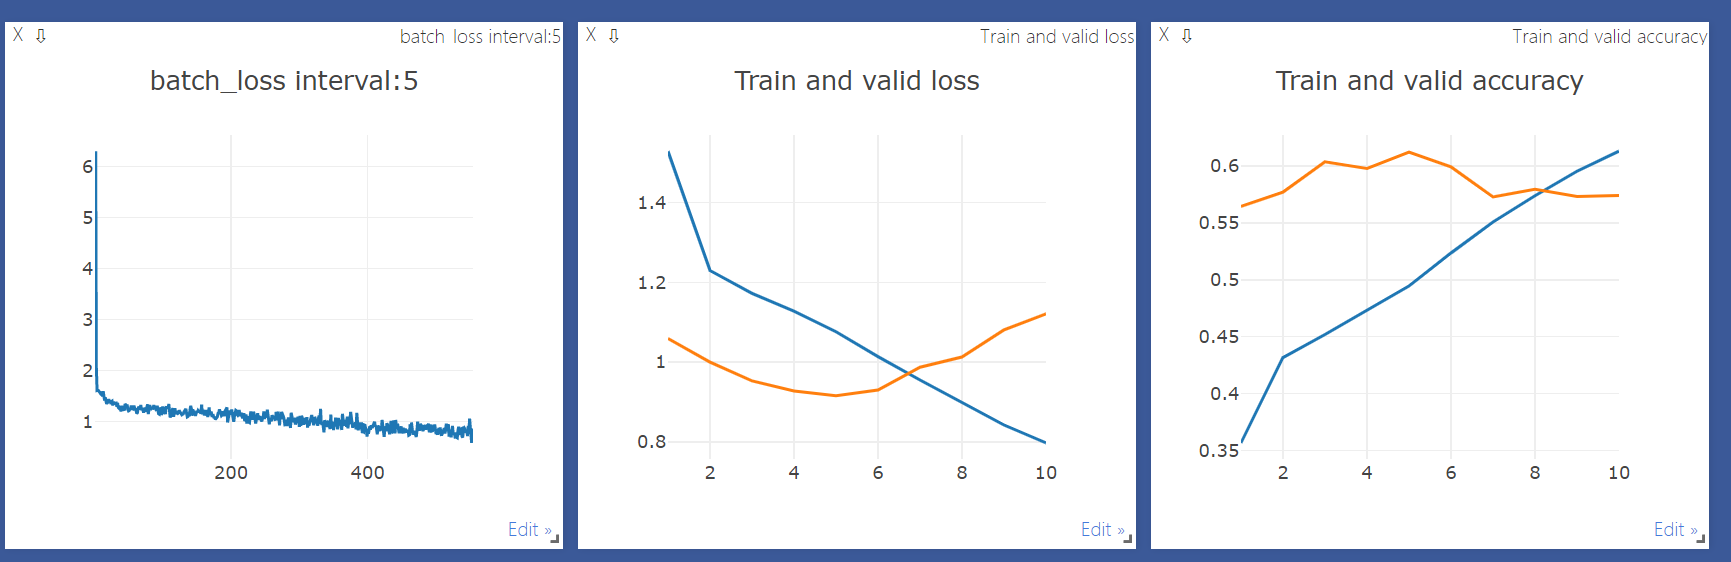

In [12]:
# 删除图片信息

In [13]:
config["use_imgs"] = False
config

{'task': 'CLS',
 'embedding_dim': 100,
 'embedding': Embedding(42834, 100),
 'freeze_embedding': False,
 'word_hidden_size': 100,
 'word_layers': 1,
 'uniform_bound': 0.1,
 'sentence_hidden_size': 100,
 'sentence_layers': 1,
 'use_imgs': False,
 'img_input_size': 4096,
 'img_output_size': 100,
 'img_num': 3,
 'dropout': 0.5,
 'output_size': 5,
 'bias_init': 1.0,
 'vocab_size': 42822}

In [14]:
batch_size = 128
workers = 6
train_loader, valid_loader, test_loader = get_loader(batch_size, workers, get_collate_fn(config), train_set, valid_set, test_set)

In [15]:
model = Model(config).cuda()
loss = nn.CrossEntropyLoss()
get_parameter_number(model), loss

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


({'Total': 4667605, 'Trainable': 4667605}, CrossEntropyLoss())

In [16]:
viz = get_Visdom()
_interval = 5
batch_loss_drawer = VisdomScalar(viz, f"batch_loss interval:{_interval}")
epoch_loss_drawer = VisdomScalar(viz, f"Train and valid loss", 2)
acc_drawer = VisdomScalar(viz, "Train and valid accuracy", 2)

batch_loss = []
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []


Setting up a new session...


In [17]:
%%time
lr = 1e-3
epoches = 20
optimizer = get_regal_optimizer(model, optim.AdamW, lr)
res, model = train_visdom(model, optimizer, loss, viz, train_loader,
                          valid_loader, epoches, batch_loss, batch_loss_drawer,
                          train_loss, valid_loss, epoch_loss_drawer,
                          train_acc, valid_acc, acc_drawer,
                         _interval=_interval)


No 1 epoch: train_loss:1.1837006186779775 train_acc:0.44711524897728877 valid_loss:1.006631030320583 valid_acc:0.5632054176072234



No 2 epoch: train_loss:0.9421015449094241 train_acc:0.5519819438566793 valid_loss:1.0460093150558645 valid_acc:0.5586907449209932



No 3 epoch: train_loss:0.8566766724581105 train_acc:0.5876146141910001 valid_loss:1.1437806389401783 valid_acc:0.5595936794582392



No 4 epoch: train_loss:0.7966195437362995 train_acc:0.6106361969248131 valid_loss:1.18310533533247 valid_acc:0.562528216704289



No 5 epoch: train_loss:0.7541928432861863 train_acc:0.6248271970658767 valid_loss:1.2717375040592511 valid_acc:0.546726862302483



No 6 epoch: train_loss:0.7244816353180157 train_acc:0.6337424178304415 valid_loss:1.3995816870144744 valid_acc:0.5415349887133183
CPU times: user 12min, sys: 1min 31s, total: 13min 31s
Wall time: 13min 32s


In [18]:
res

{'max_acc': 0.5632054176072234,
 'max_acc_epoch': 1,
 'max_train_acc': 0.44711524897728877,
 'max_acc_train_loss': 1.1837006186779775,
 'max_acc_valid_loss': 1.006631030320583,
 'last_acc': 0.5415349887133183,
 'last_train_acc': 0.6337424178304415,
 'last_epoch': 6,
 'last_train_loss': 0.7244816353180157,
 'last_valid_loss': 1.3995816870144744}

In [19]:
eval_model(model, test_loader, loss)

/home/ly/miniconda3/envs/torch1.6.0/lib/python3.7/site-packages/torch/nn/modules/rnn.py:738: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/aten/src/ATen/native/cudnn/RNN.cpp:1234.)
  self.num_layers, self.dropout, self.training, self.bidirectional)


((0.5681715575620767, 0.5659361770300637), 0.9972237163149745)